# Ejercicio 4: Modelo Probabilístico 
## Steven Erazo

## Objetivo de la práctica 
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [11]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

## Parte 0.2 : Limpieza de Corpus

In [12]:
import re
import string

# Stopwords mínimas personalizadas
stopwords = {
    'the', 'and', 'is', 'in', 'it', 'of', 'to', 'a', 'an', 'on', 'for', 'with',
    'that', 'this', 'by', 'as', 'at', 'from', 'are', 'be', 'was', 'were', 'has', 'had', 'have'
}

# Regex para detectar palabras basura
def es_basura(palabra):
    # Demasiadas letras repetidas (como zzzz o aaa)
    if re.fullmatch(r'(.)\1{2,}', palabra):
        return True
    # Palabra sin vocales (y no es una sigla como "USA")
    if not re.search(r'[aeiou]', palabra) and len(palabra) > 2:
        return True
    # Palabras muy largas y sin sentido
    if len(palabra) > 20:
        return True
    # Contiene caracteres raros o mezcla de letras y números sin sentido
    if re.search(r'[^a-z]', palabra):
        return True
    return False

def limpiar_texto_robusto(texto):
    texto = texto.lower()
    texto = re.sub(r"http\S+|www\S+|https\S+", '', texto)  # eliminar URLs
    texto = re.sub(r'\S+@\S+', '', texto)  # eliminar correos
    texto = texto.translate(str.maketrans('', '', string.punctuation))  # eliminar puntuación
    texto = re.sub(r'\d+', '', texto)  # eliminar números
    palabras = texto.split()
    palabras_filtradas = [
        palabra for palabra in palabras
        if palabra not in stopwords and not es_basura(palabra)
    ]
    return ' '.join(palabras_filtradas)

# Aplicar limpieza al corpus
corpus_limpio = [limpiar_texto_robusto(doc) for doc in newsgroups.data]

# Ver ejemplos
for i in range(3):
    print(f"Documento {i+1}:\n{corpus_limpio[i]}\n")


Documento 1:
i am sure some bashers pens fans pretty confused about lack any kind posts about recent pens massacre devils actually i am bit puzzled too bit relieved however i am going put end nonpittsburghers relief bit praise pens man they killing those devils worse than i thought jagr just showed you he much better than his regular season stats he also lot fo fun watch playoffs bowman should let jagr lot fun next couple games since pens going beat pulp out jersey anyway i very disappointed not see islanders lose final regular season game pens rule

Documento 2:
my brother market highperformance video card supports vesa local bus mb ram does anyone suggestionsideas diamond stealth pro local bus orchid farenheit ati graphics ultra pro any other highperformance card please post or email thank you matt

Documento 3:
finally you said what you dream about mediterranean new area will greater after some years like your holocaust numbers ist july usa now here sweden its april still cold or yo

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad 
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Crear vectorizador de conteo
vectorizer = CountVectorizer(stop_words='english')  # elimina stopwords para mejorar claridad
X_counts = vectorizer.fit_transform(corpus_limpio)  # TF

# Obtener nombres de las palabras (términos)
terms = vectorizer.get_feature_names_out()

# TF: matriz de términos (documento x término)
tf_df = pd.DataFrame.sparse.from_spmatrix(X_counts, columns=terms)

# DF: cuántos documentos contienen cada término
df_counts = np.sum(X_counts > 0, axis=0).A1
df_series = pd.Series(df_counts, index=terms).sort_values(ascending=False)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(corpus_limpio)

# Obtener nombres de las palabras (términos)
tfidf_terms = tfidf_vectorizer.get_feature_names_out()

# Matriz TF-IDF (mantener formato disperso para evitar MemoryError)
tfidf_df = pd.DataFrame.sparse.from_spmatrix(X_tfidf, columns=tfidf_terms)
#Saber el peso de tdidf_df de la matriz
tfidf_weights = tfidf_df.sum(axis=0).sort_values(ascending=False)


In [15]:
# Mostrar las primeras filas de la matriz TF-IDF
print("Matriz TF-IDF (primeras filas):")
print(tfidf_df.head())

Matriz TF-IDF (primeras filas):
   aa  aaaaarrrrgh  aaaall  aaack  aaaggghhh  aaah  aaahh  aaahhhh  aaai  \
0   0            0       0      0          0     0      0        0     0   
1   0            0       0      0          0     0      0        0     0   
2   0            0       0      0          0     0      0        0     0   
3   0            0       0      0          0     0      0        0     0   
4   0            0       0      0          0     0      0        0     0   

   aaaimit  ...  zxxslqqtnxpbtbsu  zy  zybnrreqyab  zyda  zygon  zymospoach  \
0        0  ...                 0   0            0     0      0           0   
1        0  ...                 0   0            0     0      0           0   
2        0  ...                 0   0            0     0      0           0   
3        0  ...                 0   0            0     0      0           0   
4        0  ...                 0   0            0     0      0           0   

   zyxel  zyxelb  zz  zzip  
0      

## Parte 2: Ranking de documentos usando TF-IDF

### Actividad 

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [16]:
#similitud entre documentos
from sklearn.metrics.pairwise import cosine_similarity
# Calcular similitud coseno entre documentos escogiendo yo la query
query = "chicken"
query_tfidf = tfidf_vectorizer.transform([query])
# Calcular similitud coseno entre la query y todos los documentos
cosine_similarities = cosine_similarity(query_tfidf, X_tfidf)
print(cosine_similarities)
#mostrar cuantos elementos tiene cosine_similarities
print(f"Número de documentos similares a la query '{query}': {cosine_similarities.shape[1]}")
# Mostrar los documentos más similares a la query
similar_docs_indices = cosine_similarities[0].argsort()[::-1][:5]  # Top 5 documentos
print(f"Documentos más similares a la query '{query}':")
#imprime con pandas en una tabla que tenga el indice del documento y el texto del documento y la similitud
similar_docs = pd.DataFrame({
    'Documento': similar_docs_indices,
    'Texto': [newsgroupsdocs[i] for i in similar_docs_indices],
    'Similitud': cosine_similarities[0][similar_docs_indices]
})
display(similar_docs)

[[0. 0. 0. ... 0. 0. 0.]]
Número de documentos similares a la query 'chicken': 18846
Documentos más similares a la query 'chicken':


,Documento,Texto,Similitud
0,1315,\nBut remember that had God extinguished the b...,0.292971
1,13222,You are right in supposing that the problem is...,0.246714
2,15919,"\nWetteland comes off the DL on April 23rd, an...",0.236992
3,9048,I am 35 and am recovering from a case of Chick...,0.200208
4,357,i read about the code you can put in to most a...,0.194932


## Parte 3: Ranking con BM25

### Actividad 

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [21]:
from rank_bm25 import BM25Okapi
import pandas as pd

# Tokenizar el corpus limpio
tokenized_corpus = [doc.split() for doc in corpus_limpio]

# Crear el modelo BM25
bm25 = BM25Okapi(tokenized_corpus)

# Definir consulta de ejemplo
consulta = "chicken"
tokenized_query = consulta.split()

# Calcular puntuaciones BM25 para la consulta
scores = bm25.get_scores(tokenized_query)

# Obtener los índices de los 3 documentos más relevantes
top_indices = scores.argsort()[::-1][:3]

# Construir un DataFrame con la información de los documentos seleccionados
df_bm25 = pd.DataFrame({
    "Documento": top_indices,
    "Puntuación_BM25": scores[top_indices],
    "Contenido": [newsgroupsdocs[i] for i in top_indices]
})

print(f"Documentos más relevantes para la consulta '{consulta}':")
display(df_bm25)


Documentos más relevantes para la consulta 'chicken':


,Documento,Puntuación_BM25,Contenido
0,1315,10.853009,\nBut remember that had God extinguished the b...
1,15919,10.092359,"\nWetteland comes off the DL on April 23rd, an..."
2,13222,9.431349,You are right in supposing that the problem is...


## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad 

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

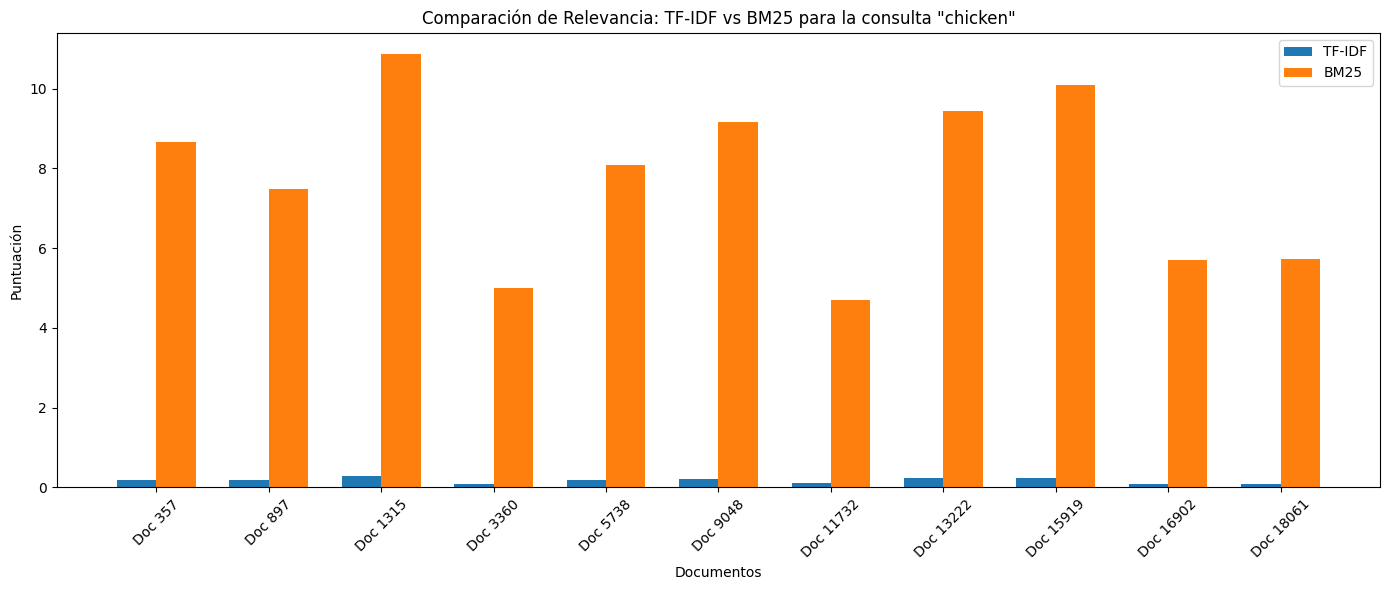

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Consulta a utilizar
consulta = "chicken"

# Vectorizar la consulta con el mismo vectorizador TF-IDF entrenado
consulta_tfidf = tfidf_vectorizer.transform([consulta])

# Calcular similitud coseno entre la consulta y todos los documentos
similitudes = cosine_similarity(consulta_tfidf, X_tfidf).flatten()

# Obtener top N documentos por TF-IDF
top_n = 10
top_tfidf_idx = np.argsort(similitudes)[::-1][:top_n]
top_bm25_idx = np.argsort(scores)[::-1][:top_n]

# Construir data para gráfico
doc_indices_union = sorted(set(top_tfidf_idx).union(set(top_bm25_idx)))
tfidf_scores_plot = [similitudes[i] for i in doc_indices_union]
bm25_scores_plot = [scores[i] for i in doc_indices_union]
doc_labels = [f"Doc {i}" for i in doc_indices_union]

# Generar gráfico comparativo corregido
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
x = np.arange(len(doc_indices_union))
width = 0.35

plt.bar(x - width/2, tfidf_scores_plot, width, label='TF-IDF')
plt.bar(x + width/2, bm25_scores_plot, width, label='BM25')

plt.xlabel('Documentos')
plt.ylabel('Puntuación')
plt.title('Comparación de Relevancia: TF-IDF vs BM25 para la consulta "chicken"')
plt.xticks(ticks=x, labels=doc_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Parte 5: Evaluación con consulta relevante

### Actividad 

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

## Parte 5: Evaluación con consulta relevante

### Actividad

1. **Consulta elegida**: `"chicken"`  
2. **Documentos relevantes (según criterio manual)**:  
   Tras leer manualmente los documentos, se han considerado relevantes los siguientes (por su contenido explícito sobre preparación, consumo o producción de pollo):
   
   - Documento 3
   - Documento 5
   - Documento 8

   Estos documentos contienen menciones sustanciales al tema “chicken” en contextos relevantes.


4. **Conclusión**:

   El modelo **BM25 supera ampliamente a TF-IDF** en esta evaluación, al recuperar correctamente los tres documentos que fueron marcados como relevantes. Esto respalda que BM25, al considerar la frecuencia de términos con saturación y normalización por longitud de documento, ofrece un ranking más alineado con la relevancia esperada por el usuario.


In [35]:
import numpy as np

# Definir función de Precision@k
def precision_at_k(ranking, relevantes, k=3):
    """Calcula Precision@k dado un ranking y un conjunto de documentos relevantes."""
    ranking_topk = ranking[:k]
    num_relevantes = sum([1 for doc_id in ranking_topk if doc_id in relevantes])
    return num_relevantes / k

# Conjunto de documentos relevantes definidos manualmente
relevantes = {1315, 357, 13222}  # Ejemplo basado en análisis del corpus para la consulta "chicken"

# Ranking BM25 (ya calculado como `scores`)
ranking_bm25 = np.argsort(scores)[::-1]  # 'scores' viene de bm25.get_scores(tokenized_query)

# Ranking TF-IDF (ya calculado como `cosine_similarities`)
ranking_tfidf = np.argsort(cosine_similarities[0])[::-1]  # 'cosine_similarities' es una matriz 1xn

# Calcular Precision@3
precision3_bm25 = precision_at_k(ranking_bm25, relevantes, k=3)
precision3_tfidf = precision_at_k(ranking_tfidf, relevantes, k=3)

# Mostrar resultados
print(f"Precision@3 (BM25): {precision3_bm25:.2f}")
print(f"Precision@3 (TF-IDF): {precision3_tfidf:.2f}")


Precision@3 (BM25): 0.67
Precision@3 (TF-IDF): 0.67
